
# Illustration of transforms

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

**References:**
- [![View filled on Github](https://img.shields.io/static/v1.svg?logo=pytorch&label=Website&message=Torchvision%20Transforms%20&color=lightgrey)](https://pytorch.org/vision/0.16/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py)
- [![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=Albumentations%20Showcase%20&color=lightgrey)](https://github.com/albumentations-team/albumentations_examples/blob/master/notebooks/showcase.ipynb)
- [![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=From%20Torchvision%20to%20Albumentations%20&color=lightgrey)](https://github.com/albumentations-team/albumentations_examples/blob/master/notebooks/migrating_from_torchvision_to_albumentations.ipynb)

This example illustrates some of the various transforms available in `the
torchvision.transforms.v2 module <transforms>`.


In [1]:
from PIL import Image
from pathlib import Path

import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = "tight"

import random 
import numpy as np 

import torch
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as F
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision import tv_tensors

In [2]:
def random_seed(seed: int = 42, rank: int = 0, deterministic: bool = False) -> None:
    torch.manual_seed(seed + rank)
    np.random.seed(seed + rank)
    random.seed(seed + rank)
    # GPU operations have a separate seed we also want to set
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed + rank)
        torch.cuda.manual_seed_all(seed + rank)

        # Additionally, some operations on a GPU are implemented stochastic for efficiency
        # We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
        torch.backends.cudnn.deterministic = deterministic
        torch.backends.cudnn.benchmark = True


random_seed(deterministic=True)

In [3]:
def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(
                    img,
                    masks.to(torch.bool),
                    colors=["green"] * masks.shape[0],
                    alpha=0.65,
                )

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [4]:
orig_img = Image.open('./astronaut.jpg')

## Geometric Transforms
Geometric image transformation refers to the process of altering the geometric properties of an image,
such as its shape, size, orientation, or position.
It involves applying mathematical operations to the image pixels or coordinates to achieve the desired transformation.

### Pad
The :class:`~torchvision.transforms.Pad` transform
(see also :func:`~torchvision.transforms.functional.pad`)
pads all image borders with some pixel values.



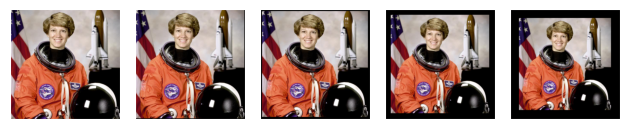

In [5]:
padded_imgs = [v2.Pad(padding=padding)(orig_img) for padding in (3, 10, 30, 50)]
plot([orig_img] + padded_imgs)

### Resize
The :class:`~torchvision.transforms.Resize` transform
(see also :func:`~torchvision.transforms.functional.resize`)
resizes an image.



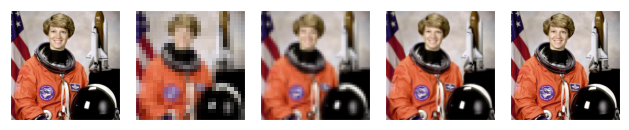

In [6]:
resized_imgs = [v2.Resize(size=size)(orig_img) for size in (30, 50, 100, orig_img.size)]
plot([orig_img] + resized_imgs)

### CenterCrop
The :class:`~torchvision.transforms.CenterCrop` transform
(see also :func:`~torchvision.transforms.functional.center_crop`)
crops the given image at the center.



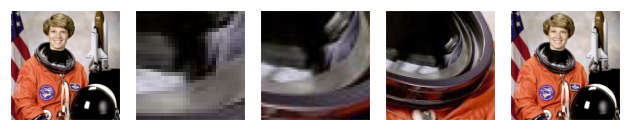

In [7]:
center_crops = [v2.CenterCrop(size=size)(orig_img) for size in (30, 50, 100, orig_img.size)]
plot([orig_img] + center_crops)

### FiveCrop
The :class:`~torchvision.transforms.FiveCrop` transform
(see also :func:`~torchvision.transforms.functional.five_crop`)
crops the given image into four corners and the central crop.



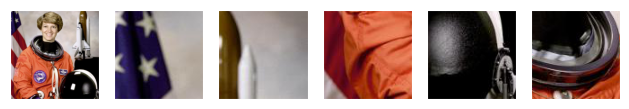

In [8]:
(top_left, top_right, bottom_left, bottom_right, center) = v2.FiveCrop(size=(100, 100))(orig_img)
plot([orig_img] + [top_left, top_right, bottom_left, bottom_right, center])

### RandomPerspective
The :class:`~torchvision.transforms.RandomPerspective` transform
(see also :func:`~torchvision.transforms.functional.perspective`)
performs random perspective transform on an image.



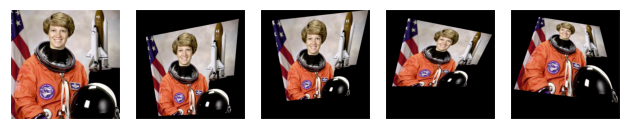

In [9]:
perspective_transformer = v2.RandomPerspective(distortion_scale=0.6, p=1.0)
perspective_imgs = [perspective_transformer(orig_img) for _ in range(4)]
plot([orig_img] + perspective_imgs)

### RandomRotation
The :class:`~torchvision.transforms.RandomRotation` transform
(see also :func:`~torchvision.transforms.functional.rotate`)
rotates an image with random angle.



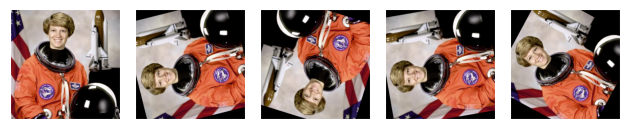

In [10]:
rotater = v2.RandomRotation(degrees=(0, 180))
rotated_imgs = [rotater(orig_img) for _ in range(4)]
plot([orig_img] + rotated_imgs)

### RandomAffine
The :class:`~torchvision.transforms.RandomAffine` transform
(see also :func:`~torchvision.transforms.functional.affine`)
performs random affine transform on an image.



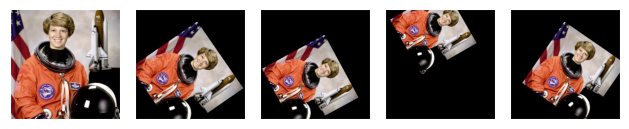

In [11]:
affine_transfomer = v2.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75))
affine_imgs = [affine_transfomer(orig_img) for _ in range(4)]
plot([orig_img] + affine_imgs)

### ElasticTransform
The :class:`~torchvision.transforms.ElasticTransform` transform
(see also :func:`~torchvision.transforms.functional.elastic_transform`)
Randomly transforms the morphology of objects in images and produces a
see-through-water-like effect.



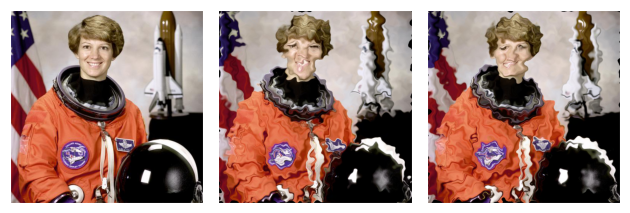

In [12]:
elastic_transformer = v2.ElasticTransform(alpha=250.0)
transformed_imgs = [elastic_transformer(orig_img) for _ in range(2)]
plot([orig_img] + transformed_imgs)

### RandomCrop
The :class:`~torchvision.transforms.RandomCrop` transform
(see also :func:`~torchvision.transforms.functional.crop`)
crops an image at a random location.



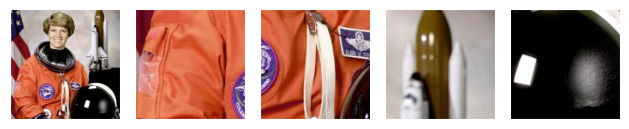

In [13]:
cropper = v2.RandomCrop(size=(128, 128))
crops = [cropper(orig_img) for _ in range(4)]
plot([orig_img] + crops)

### RandomResizedCrop
The :class:`~torchvision.transforms.RandomResizedCrop` transform
(see also :func:`~torchvision.transforms.functional.resized_crop`)
crops an image at a random location, and then resizes the crop to a given
size.



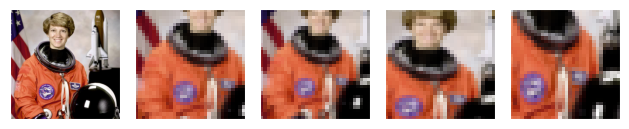

In [14]:
resize_cropper = v2.RandomResizedCrop(size=(32, 32))
resized_crops = [resize_cropper(orig_img) for _ in range(4)]
plot([orig_img] + resized_crops)

## Photometric Transforms
Photometric image transformation refers to the process of modifying the photometric properties of an image,
such as its brightness, contrast, color, or tone.
These transformations are applied to change the visual appearance of an image
while preserving its geometric structure.

Except :class:`~torchvision.transforms.Grayscale`, the following transforms are random,
which means that the same transform
instance will produce different result each time it transforms a given image.

### Grayscale
The :class:`~torchvision.transforms.Grayscale` transform
(see also :func:`~torchvision.transforms.functional.to_grayscale`)
converts an image to grayscale



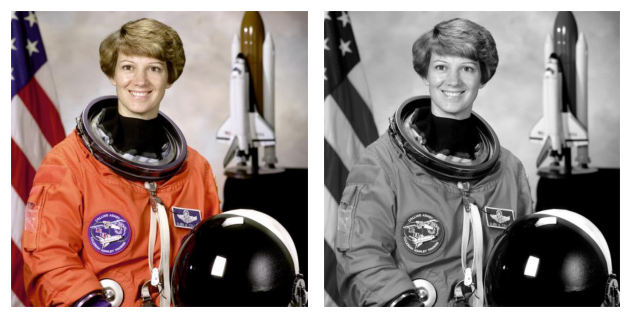

In [15]:
gray_img = v2.Grayscale()(orig_img)
plot([orig_img, gray_img], cmap='gray')

### ColorJitter
The :class:`~torchvision.transforms.ColorJitter` transform
randomly changes the brightness, contrast, saturation, hue, and other properties of an image.



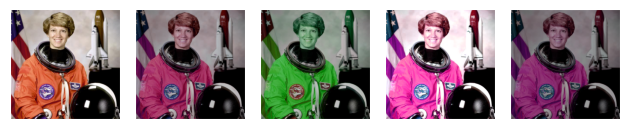

In [16]:
jitter = v2.ColorJitter(brightness=.5, hue=.3)
jittered_imgs = [jitter(orig_img) for _ in range(4)]
plot([orig_img] + jittered_imgs)

### GaussianBlur
The :class:`~torchvision.transforms.GaussianBlur` transform
(see also :func:`~torchvision.transforms.functional.gaussian_blur`)
performs gaussian blur transform on an image.



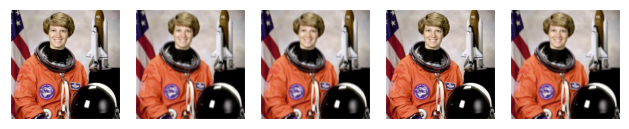

In [17]:
blurrer = v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.))
blurred_imgs = [blurrer(orig_img) for _ in range(4)]
plot([orig_img] + blurred_imgs)

### RandomInvert
The :class:`~torchvision.transforms.RandomInvert` transform
(see also :func:`~torchvision.transforms.functional.invert`)
randomly inverts the colors of the given image.



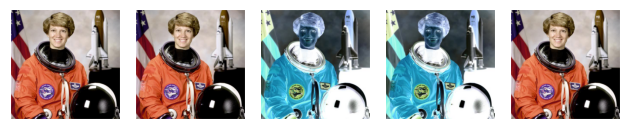

In [18]:
inverter = v2.RandomInvert()
invertered_imgs = [inverter(orig_img) for _ in range(4)]
plot([orig_img] + invertered_imgs)

### RandomPosterize
The :class:`~torchvision.transforms.RandomPosterize` transform
(see also :func:`~torchvision.transforms.functional.posterize`)
randomly posterizes the image by reducing the number of bits
of each color channel.



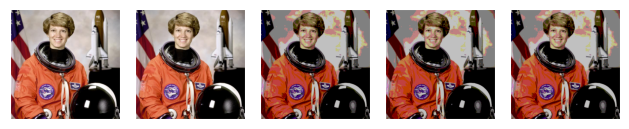

In [19]:
posterizer = v2.RandomPosterize(bits=2)
posterized_imgs = [posterizer(orig_img) for _ in range(4)]
plot([orig_img] + posterized_imgs)

### RandomSolarize
The :class:`~torchvision.transforms.RandomSolarize` transform
(see also :func:`~torchvision.transforms.functional.solarize`)
randomly solarizes the image by inverting all pixel values above
the threshold.



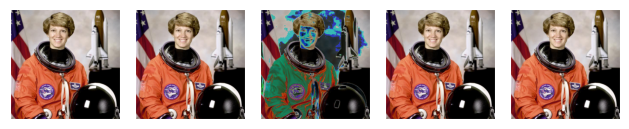

In [20]:
solarizer = v2.RandomSolarize(threshold=192.0)
solarized_imgs = [solarizer(orig_img) for _ in range(4)]
plot([orig_img] + solarized_imgs)

### RandomAdjustSharpness
The :class:`~torchvision.transforms.RandomAdjustSharpness` transform
(see also :func:`~torchvision.transforms.functional.adjust_sharpness`)
randomly adjusts the sharpness of the given image.



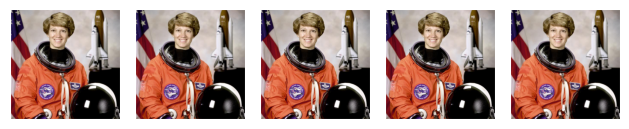

In [21]:
sharpness_adjuster = v2.RandomAdjustSharpness(sharpness_factor=2)
sharpened_imgs = [sharpness_adjuster(orig_img) for _ in range(4)]
plot([orig_img] + sharpened_imgs)

### RandomAutocontrast
The :class:`~torchvision.transforms.RandomAutocontrast` transform
(see also :func:`~torchvision.transforms.functional.autocontrast`)
randomly applies autocontrast to the given image.



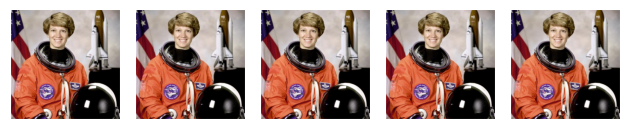

In [22]:
autocontraster = v2.RandomAutocontrast()
autocontrasted_imgs = [autocontraster(orig_img) for _ in range(4)]
plot([orig_img] + autocontrasted_imgs)

### RandomEqualize
The :class:`~torchvision.transforms.RandomEqualize` transform
(see also :func:`~torchvision.transforms.functional.equalize`)
randomly equalizes the histogram of the given image.



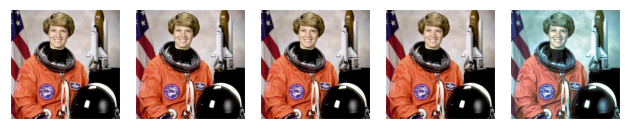

In [23]:
equalizer = v2.RandomEqualize()
equalized_imgs = [equalizer(orig_img) for _ in range(4)]
plot([orig_img] + equalized_imgs)

## Augmentation Transforms
The following transforms are combinations of multiple transforms,
either geometric or photometric, or both.

### AutoAugment
The :class:`~torchvision.transforms.AutoAugment` transform
automatically augments data based on a given auto-augmentation policy.
See :class:`~torchvision.transforms.AutoAugmentPolicy` for the available policies.



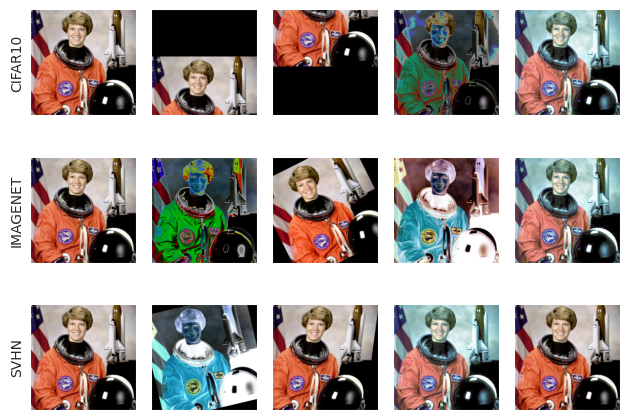

In [24]:
policies = [v2.AutoAugmentPolicy.CIFAR10, v2.AutoAugmentPolicy.IMAGENET, v2.AutoAugmentPolicy.SVHN]
augmenters = [v2.AutoAugment(policy) for policy in policies]
imgs = [
    [augmenter(orig_img) for _ in range(4)]
    for augmenter in augmenters
]
row_title = [str(policy).split('.')[-1] for policy in policies]
plot([[orig_img] + row for row in imgs], row_title=row_title)

### RandAugment
The :class:`~torchvision.transforms.RandAugment` is an alternate version of AutoAugment.



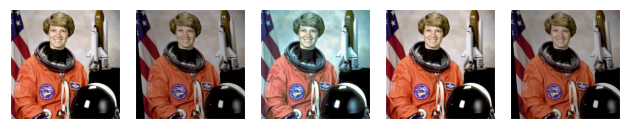

In [25]:
augmenter = v2.RandAugment()
imgs = [augmenter(orig_img) for _ in range(4)]
plot([orig_img] + imgs)

### TrivialAugmentWide
The :class:`~torchvision.transforms.TrivialAugmentWide` is an alternate implementation of AutoAugment.
However, instead of transforming an image multiple times, it transforms an image only once
using a random transform from a given list with a random strength number.



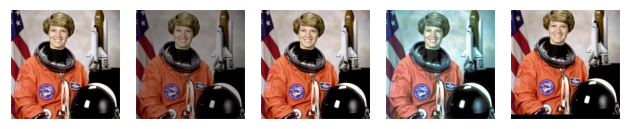

In [26]:
augmenter = v2.TrivialAugmentWide()
imgs = [augmenter(orig_img) for _ in range(4)]
plot([orig_img] + imgs)

### AugMix
The :class:`~torchvision.transforms.AugMix` transform interpolates between augmented versions of an image.



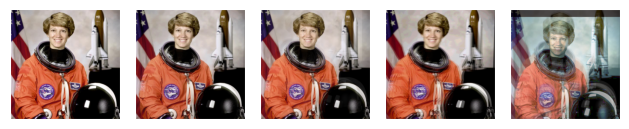

In [27]:
augmenter = v2.AugMix()
imgs = [augmenter(orig_img) for _ in range(4)]
plot([orig_img] + imgs)

## Randomly-applied Transforms

The following transforms are randomly-applied given a probability ``p``.  That is, given ``p = 0.5``,
there is a 50% chance to return the original image, and a 50% chance to return the transformed image,
even when called with the same transform instance!

### RandomHorizontalFlip
The :class:`~torchvision.transforms.RandomHorizontalFlip` transform
(see also :func:`~torchvision.transforms.functional.hflip`)
performs horizontal flip of an image, with a given probability.



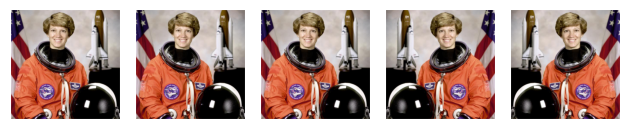

In [28]:
hflipper = v2.RandomHorizontalFlip(p=0.5)
transformed_imgs = [hflipper(orig_img) for _ in range(4)]
plot([orig_img] + transformed_imgs)

### RandomVerticalFlip
The :class:`~torchvision.transforms.RandomVerticalFlip` transform
(see also :func:`~torchvision.transforms.functional.vflip`)
performs vertical flip of an image, with a given probability.



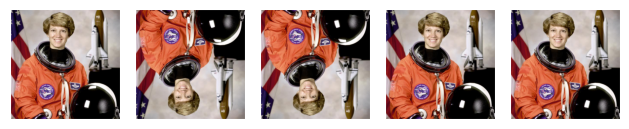

In [29]:
vflipper = v2.RandomVerticalFlip(p=0.5)
transformed_imgs = [vflipper(orig_img) for _ in range(4)]
plot([orig_img] + transformed_imgs)

### RandomApply
The :class:`~torchvision.transforms.RandomApply` transform
randomly applies a list of transforms, with a given probability.



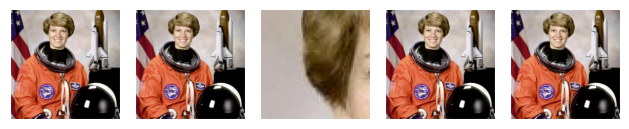

In [30]:
applier = v2.RandomApply(transforms=[v2.RandomCrop(size=(64, 64))], p=0.5)
transformed_imgs = [applier(orig_img) for _ in range(4)]
plot([orig_img] + transformed_imgs)